In [42]:
%matplotlib inline
import GEOparse
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import explained_variance_score, plot_roc_curve
import statsmodels.api as sm
from scipy.stats import ttest_ind
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklego.linear_model import LowessRegression

### Reading in from external source

In [43]:
geo = "GSE40738"
data = GEOparse.get_GEO(geo=geo, destdir="../Dataset/Patnaik2017", silent=True)
#table = pd.read_csv("../Dataset/Fehlman2020/expression_matrix.csv", sep="\t")
#table = pd.read_csv("../Dataset/Wozniak2015/GSE64591_non-normalized.txt", sep="\t", header=5)

In [44]:
list(data.gsms.values())[0].metadata

{'title': ['cancer preop 1'],
 'geo_accession': ['GSM1000223'],
 'status': ['Public on Sep 11 2012'],
 'submission_date': ['Sep 10 2012'],
 'last_update_date': ['Sep 11 2012'],
 'type': ['RNA'],
 'channel_count': ['2'],
 'source_name_ch1': ['blood, lung cancer, individual 1'],
 'organism_ch1': ['Homo sapiens'],
 'taxid_ch1': ['9606'],
 'characteristics_ch1': ['tissue: blood',
  'time: preop',
  'gender: female',
  'age: 41 y',
  'disease state: adenocarcinoma of lung',
  'lung disease: Lung cancer (before surgical resection of lung cancer)',
  'individual: 1'],
 'molecule_ch1': ['total RNA'],
 'extract_protocol_ch1': ['Total RNA was isolated from blood collected and stored in PAXgene Blood RNA tubes using a PAXgene Blood miRNA kit at the Roswell Park Cancer Institute, Buffalo, NY, USA as per the protocol suggested by the manufacturer (Qiagen, Valencia, CA, USA). The human universal reference RNA was made by pooling contents of FirstChoice total RNA panel that is made of RNA from differ

In [45]:
table = pd.concat((val.table.iloc[:,1:] for val in data.gsms.values()), axis=1).transpose()
mirnas = list(data.gsms.values())[0].table.iloc[:,0]
gsm_list = np.array(list(data.gsms.values()))

In [46]:
table

,0,1,2,3,4,5,6,7,8,9,...,3537,3538,3539,3540,3541,3542,3543,3544,3545,3546
VALUE,0.010494,-1.407409,1.475053,-3.202545,-0.559560,0.026980,-0.732104,-3.151635,0.444564,0.677118,...,-0.189455,-0.671585,-1.955679,-1.516398,0.094447,-1.569766,-0.678858,-0.559935,-0.656613,-0.619179
VALUE,-0.046461,-1.683871,1.405158,-3.574522,-0.319152,0.269934,-0.604729,-3.084154,0.485789,0.328734,...,-0.032436,-0.611187,-2.025718,-1.464776,0.274390,-1.174481,-0.627605,-0.669845,-0.562442,-0.814464
VALUE,-0.434401,-1.779390,1.471687,-4.407035,-1.026731,0.326473,-0.602487,-3.589156,0.591669,-0.187806,...,-0.204983,-0.621601,-2.275938,-1.417229,-0.134084,-1.447181,-0.809580,-0.727625,-0.659716,-0.742287
VALUE,-0.700871,-1.586739,1.384012,-2.408802,0.082291,0.109722,-0.572143,-1.415818,0.576520,0.787149,...,0.035057,-0.603761,-2.322062,-1.593372,-0.101195,0.183775,-0.868510,-0.166346,-0.547396,-0.721662
VALUE,-0.260650,-1.182717,1.335324,-3.541777,-1.094086,0.426749,-0.391624,-3.103124,0.402727,0.474227,...,-0.396745,-0.733530,-1.607247,-1.423773,-0.114282,-0.726970,-0.730110,-0.739246,-1.010341,-0.846827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VALUE,-0.849401,-1.704188,1.258121,-3.291897,-0.940261,0.081012,-0.610622,-2.702150,0.458538,0.781526,...,-0.084094,-0.694373,-1.750953,-1.581935,0.257665,-1.039112,-0.704940,-0.658960,-0.523236,-0.792110
VALUE,-1.095159,-1.811575,1.403459,-2.535752,-0.406089,0.000447,-0.679938,-2.384535,0.662613,1.218111,...,-0.204615,-0.554988,-1.834644,-1.612957,0.286119,-1.180161,0.519697,-0.745760,-0.501697,-0.810299
VALUE,-1.464105,-2.018576,1.523334,-3.172166,-0.256080,0.373576,-0.635107,-2.487154,0.482363,0.923342,...,-0.082325,-0.701619,-2.009718,-1.720748,-0.314919,-1.789872,-0.669051,-0.583276,-0.446627,-0.845082
VALUE,-0.700562,-1.508051,1.556278,-4.315787,-1.884412,0.475398,-0.576680,-3.827294,0.632676,-0.362867,...,0.078660,-0.920747,-1.929514,-1.702724,0.049282,-1.007424,-0.663182,-0.437739,-0.386830,-0.713551


### Get controls

In [47]:
set([list(data.gsms.values())[i].metadata["title"][0] for i in range(177)])

{'cancer postop 1',
 'cancer postop 10',
 'cancer postop 11',
 'cancer postop 12',
 'cancer postop 13',
 'cancer postop 2',
 'cancer postop 2 later timepoint',
 'cancer postop 3',
 'cancer postop 4',
 'cancer postop 5',
 'cancer postop 6',
 'cancer postop 7',
 'cancer postop 8',
 'cancer postop 9',
 'cancer preop 1',
 'cancer preop 10',
 'cancer preop 11',
 'cancer preop 12',
 'cancer preop 13',
 'cancer preop 14',
 'cancer preop 15',
 'cancer preop 16',
 'cancer preop 17',
 'cancer preop 18',
 'cancer preop 19',
 'cancer preop 2',
 'cancer preop 20',
 'cancer preop 21',
 'cancer preop 22',
 'cancer preop 23',
 'cancer preop 24',
 'cancer preop 25',
 'cancer preop 26',
 'cancer preop 27',
 'cancer preop 28',
 'cancer preop 29',
 'cancer preop 3',
 'cancer preop 30',
 'cancer preop 31',
 'cancer preop 32',
 'cancer preop 33',
 'cancer preop 34',
 'cancer preop 35',
 'cancer preop 36',
 'cancer preop 37',
 'cancer preop 38',
 'cancer preop 39',
 'cancer preop 4',
 'cancer preop 40',
 'ca

### Remove postop

In [48]:
mask = np.array(["postop" not in k.metadata["title"][0] for k in gsm_list])
table = table.loc[mask]
gsm_list = gsm_list[mask]

### Seperate case and controls

In [49]:
controls = np.array(["control" in k.metadata["title"][0] for k in gsm_list])
sick = 1 - controls

In [50]:
sum(controls)

77

### Drop NAN

In [51]:
table.isna().sum().sum()

0

In [52]:
table = table.dropna(1)

C:\Users\olefr\AppData\Local\Temp/ipykernel_11388/1927661217.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  table = table.dropna(1)


### T-test

In [53]:
X = table

In [54]:
X

,0,1,2,3,4,5,6,7,8,9,...,3537,3538,3539,3540,3541,3542,3543,3544,3545,3546
VALUE,0.010494,-1.407409,1.475053,-3.202545,-0.559560,0.026980,-0.732104,-3.151635,0.444564,0.677118,...,-0.189455,-0.671585,-1.955679,-1.516398,0.094447,-1.569766,-0.678858,-0.559935,-0.656613,-0.619179
VALUE,-0.046461,-1.683871,1.405158,-3.574522,-0.319152,0.269934,-0.604729,-3.084154,0.485789,0.328734,...,-0.032436,-0.611187,-2.025718,-1.464776,0.274390,-1.174481,-0.627605,-0.669845,-0.562442,-0.814464
VALUE,-0.434401,-1.779390,1.471687,-4.407035,-1.026731,0.326473,-0.602487,-3.589156,0.591669,-0.187806,...,-0.204983,-0.621601,-2.275938,-1.417229,-0.134084,-1.447181,-0.809580,-0.727625,-0.659716,-0.742287
VALUE,-0.700871,-1.586739,1.384012,-2.408802,0.082291,0.109722,-0.572143,-1.415818,0.576520,0.787149,...,0.035057,-0.603761,-2.322062,-1.593372,-0.101195,0.183775,-0.868510,-0.166346,-0.547396,-0.721662
VALUE,-0.260650,-1.182717,1.335324,-3.541777,-1.094086,0.426749,-0.391624,-3.103124,0.402727,0.474227,...,-0.396745,-0.733530,-1.607247,-1.423773,-0.114282,-0.726970,-0.730110,-0.739246,-1.010341,-0.846827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VALUE,-0.849401,-1.704188,1.258121,-3.291897,-0.940261,0.081012,-0.610622,-2.702150,0.458538,0.781526,...,-0.084094,-0.694373,-1.750953,-1.581935,0.257665,-1.039112,-0.704940,-0.658960,-0.523236,-0.792110
VALUE,-1.095159,-1.811575,1.403459,-2.535752,-0.406089,0.000447,-0.679938,-2.384535,0.662613,1.218111,...,-0.204615,-0.554988,-1.834644,-1.612957,0.286119,-1.180161,0.519697,-0.745760,-0.501697,-0.810299
VALUE,-1.464105,-2.018576,1.523334,-3.172166,-0.256080,0.373576,-0.635107,-2.487154,0.482363,0.923342,...,-0.082325,-0.701619,-2.009718,-1.720748,-0.314919,-1.789872,-0.669051,-0.583276,-0.446627,-0.845082
VALUE,-0.700562,-1.508051,1.556278,-4.315787,-1.884412,0.475398,-0.576680,-3.827294,0.632676,-0.362867,...,0.078660,-0.920747,-1.929514,-1.702724,0.049282,-1.007424,-0.663182,-0.437739,-0.386830,-0.713551


In [55]:
X_healthy, X_cancer = X[controls == 1], X[sick == 1]

In [56]:
results = ttest_ind(X_healthy, X_cancer).pvalue

In [57]:
lowest, pvalues = np.argsort(results)[:5], np.sort(results)[:5]

In [58]:
mirnas.iloc[lowest], pvalues

(2280    148276
 2958    168828
 1016     42953
 913      42823
 1450    145988
 Name: ID_REF, dtype: int64,
 array([1.06819761e-05, 1.09182673e-05, 2.47977493e-05, 2.49944720e-05,
        2.53269565e-05]))

### F-test

In [59]:
t3 = table

In [60]:
f, p = f_classif(t3, sick)

In [61]:
np.mean(p)

0.39949717150584324

### ANOVA

In [62]:
t3

,0,1,2,3,4,5,6,7,8,9,...,3537,3538,3539,3540,3541,3542,3543,3544,3545,3546
VALUE,0.010494,-1.407409,1.475053,-3.202545,-0.559560,0.026980,-0.732104,-3.151635,0.444564,0.677118,...,-0.189455,-0.671585,-1.955679,-1.516398,0.094447,-1.569766,-0.678858,-0.559935,-0.656613,-0.619179
VALUE,-0.046461,-1.683871,1.405158,-3.574522,-0.319152,0.269934,-0.604729,-3.084154,0.485789,0.328734,...,-0.032436,-0.611187,-2.025718,-1.464776,0.274390,-1.174481,-0.627605,-0.669845,-0.562442,-0.814464
VALUE,-0.434401,-1.779390,1.471687,-4.407035,-1.026731,0.326473,-0.602487,-3.589156,0.591669,-0.187806,...,-0.204983,-0.621601,-2.275938,-1.417229,-0.134084,-1.447181,-0.809580,-0.727625,-0.659716,-0.742287
VALUE,-0.700871,-1.586739,1.384012,-2.408802,0.082291,0.109722,-0.572143,-1.415818,0.576520,0.787149,...,0.035057,-0.603761,-2.322062,-1.593372,-0.101195,0.183775,-0.868510,-0.166346,-0.547396,-0.721662
VALUE,-0.260650,-1.182717,1.335324,-3.541777,-1.094086,0.426749,-0.391624,-3.103124,0.402727,0.474227,...,-0.396745,-0.733530,-1.607247,-1.423773,-0.114282,-0.726970,-0.730110,-0.739246,-1.010341,-0.846827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VALUE,-0.849401,-1.704188,1.258121,-3.291897,-0.940261,0.081012,-0.610622,-2.702150,0.458538,0.781526,...,-0.084094,-0.694373,-1.750953,-1.581935,0.257665,-1.039112,-0.704940,-0.658960,-0.523236,-0.792110
VALUE,-1.095159,-1.811575,1.403459,-2.535752,-0.406089,0.000447,-0.679938,-2.384535,0.662613,1.218111,...,-0.204615,-0.554988,-1.834644,-1.612957,0.286119,-1.180161,0.519697,-0.745760,-0.501697,-0.810299
VALUE,-1.464105,-2.018576,1.523334,-3.172166,-0.256080,0.373576,-0.635107,-2.487154,0.482363,0.923342,...,-0.082325,-0.701619,-2.009718,-1.720748,-0.314919,-1.789872,-0.669051,-0.583276,-0.446627,-0.845082
VALUE,-0.700562,-1.508051,1.556278,-4.315787,-1.884412,0.475398,-0.576680,-3.827294,0.632676,-0.362867,...,0.078660,-0.920747,-1.929514,-1.702724,0.049282,-1.007424,-0.663182,-0.437739,-0.386830,-0.713551


In [63]:
X = np.array(sick).reshape(-1, 1)

In [64]:
linreg = LinearRegression()
linreg.fit(X, t3)

LinearRegression()

In [65]:
fitted = linreg.predict(X)
explained_variance_score(t3, fitted)

0.010860571135169809

### Mean-variance-plot

In [66]:
np.mean(table)

0      -0.604452
1      -1.596269
2       1.408494
3      -3.739683
4      -1.115383
          ...   
3542   -1.511151
3543   -0.765627
3544   -0.555159
3545   -0.550201
3546   -0.769894
Length: 3547, dtype: float64

In [67]:
def get_means_and_variances(table):
    return np.mean(table), np.var(table, ddof=1)

In [68]:
def mean_variance_plot(table):
    means, variances = get_means_and_variances(table)
    plt.scatter(means, variances)
    plt.xlabel("mean")
    plt.ylabel("variance")
    plt.plot()

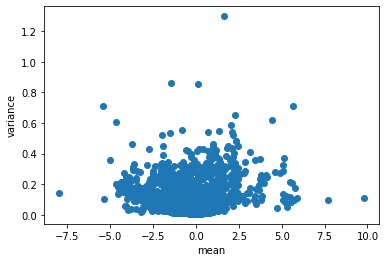

In [69]:
mean_variance_plot(table)

### Log transformation

In [70]:
log_table = table #np.log2(table)

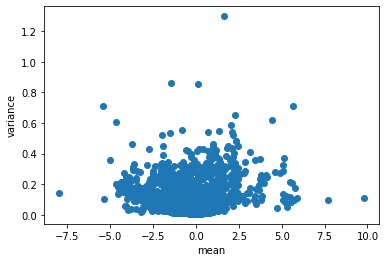

In [71]:
mean_variance_plot(log_table)

In [72]:
norm_log_table = log_table - np.mean(log_table)

In [73]:
norm_log_table /= np.sqrt(np.mean(np.var(norm_log_table, ddof=1)))

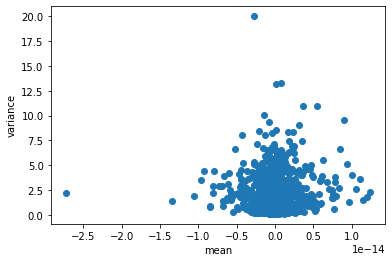

In [74]:
mean_variance_plot(norm_log_table)

### PCA

In [75]:
pca = decomposition.PCA(n_components=10)

In [76]:
pca.fit(norm_log_table)

PCA(n_components=10)

In [77]:
pca.explained_variance_ratio_

array([0.118042  , 0.10529381, 0.08550708, 0.06696114, 0.05081276,
       0.04746768, 0.03730284, 0.03182292, 0.0284573 , 0.02488633])

In [78]:
components = pca.transform(norm_log_table)

In [79]:
components.shape

(163, 10)

In [80]:
sum(controls)

77

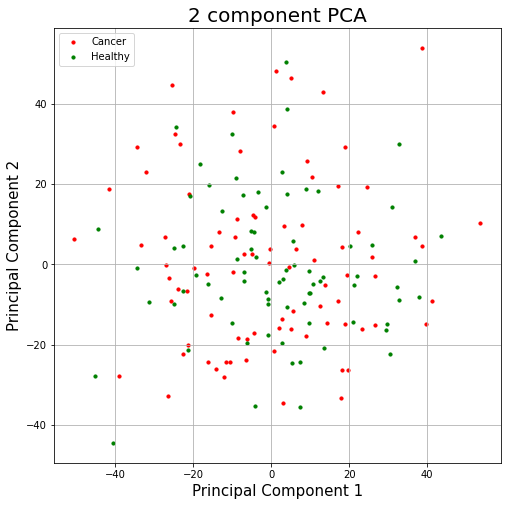

In [81]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components[controls == False, 0], components[controls == False, 1], c = 'r', s = 10)
ax.scatter(components[controls == True, 0], components[controls == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

In [82]:
components2 = components[components[:,0] < 20, :]
controls2 = controls[components[:,0] < 20]

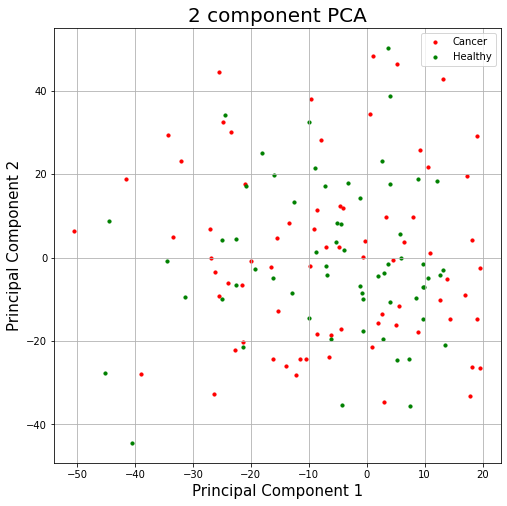

In [83]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components2[controls2 == False, 0], components2[controls2 == False, 1], c = 'r', s = 10)
ax.scatter(components2[controls2 == True, 0], components2[controls2 == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

### Linear regression adjustments

In [84]:
gsm_list[30].metadata

{'title': ['control highrisk 12'],
 'geo_accession': ['GSM1000253'],
 'status': ['Public on Sep 11 2012'],
 'submission_date': ['Sep 10 2012'],
 'last_update_date': ['Sep 11 2012'],
 'type': ['RNA'],
 'channel_count': ['2'],
 'source_name_ch1': ['blood, no lung cancer or nodule, individual 115'],
 'organism_ch1': ['Homo sapiens'],
 'taxid_ch1': ['9606'],
 'characteristics_ch1': ['tissue: blood',
  'gender: male',
  'age: 57 y',
  'disease state: lung without lung cancer or non-cancerous nodule',
  'lung disease: None (no current or past lung cancer or non-cancerous nodule)',
  'individual: 115'],
 'molecule_ch1': ['total RNA'],
 'extract_protocol_ch1': ['Total RNA was isolated from blood collected and stored in PAXgene Blood RNA tubes using a PAXgene Blood miRNA kit at the Roswell Park Cancer Institute, Buffalo, NY, USA as per the protocol suggested by the manufacturer (Qiagen, Valencia, CA, USA). The human universal reference RNA was made by pooling contents of FirstChoice total RNA p

In [85]:
sex = np.array(["female" in k.metadata["characteristics_ch1"][2] if "gender" in k.metadata["characteristics_ch1"][2] else "female" in k.metadata["characteristics_ch1"][1] for k in gsm_list])
age = np.array([float(k.metadata["characteristics_ch1"][3].split(" ")[1].replace("NA", "NaN")) if "age" in k.metadata["characteristics_ch1"][3] else float(k.metadata["characteristics_ch1"][2].split(" ")[1].replace("NA", "NaN")) for k in gsm_list])

In [86]:
covars = pd.DataFrame(np.array([sex, age]).transpose(), columns=["sex", "age"])

In [87]:
covars = covars.fillna(covars.mean())

In [88]:
linreg = LinearRegression()
linreg.fit(covars, norm_log_table)

LinearRegression()

In [89]:
adj_norm_log_table = norm_log_table - linreg.predict(covars)

# PCA

In [90]:
pca = decomposition.PCA(n_components=2)

In [91]:
pca.fit(adj_norm_log_table)

PCA(n_components=2)

In [92]:
components = pca.transform(adj_norm_log_table)

In [93]:
components

array([[ 12.61847771, -10.24477748],
       [ 18.96302733, -14.8361086 ],
       [ -0.2903837 ,   3.955851  ],
       [ 53.66552444,  10.31294522],
       [  7.9117214 ,   9.78385621],
       [  2.93974548, -34.55521389],
       [  0.8445088 , -21.47601674],
       [ 17.82534988, -33.2518731 ],
       [ 36.94190925,   6.84249542],
       [ 21.2913773 ,  -5.18159097],
       [ 29.69554182, -14.85708369],
       [  9.68763692, -14.67155476],
       [ 22.13043721,  -2.82610781],
       [ 12.05317218,  18.3216687 ],
       [ -4.2345321 , -35.28171402],
       [ 32.87394016,  -8.82927715],
       [  5.71375321,   5.72484624],
       [  7.28830905, -24.22810741],
       [  5.28972485, -24.49321107],
       [ 10.95200127,   1.1086683 ],
       [ 22.39439697,   8.07700344],
       [ 18.20620724,   4.2349582 ],
       [ 19.04377337,  29.15249394],
       [  9.19912958,  25.7465161 ],
       [ 18.09402561, -26.20553226],
       [ 38.62877966,   4.56647195],
       [ 38.5913592 ,  53.98595942],
 

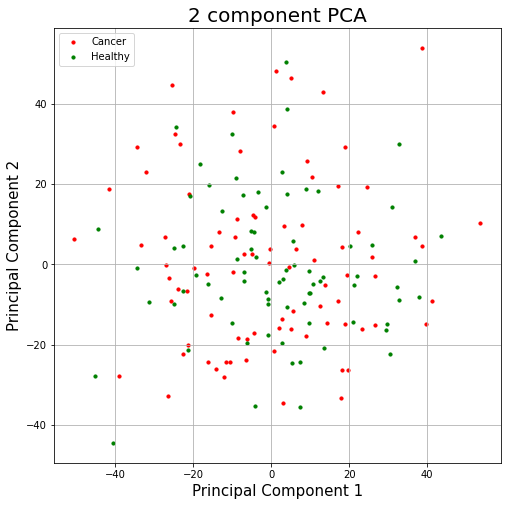

In [94]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Cancer', 'Healthy']
colors = ['r', 'g']
ax.scatter(components[controls == False, 0], components[controls == False, 1], c = 'r', s = 10)
ax.scatter(components[controls == True, 0], components[controls == True, 1], c = 'g', s = 10)
ax.legend(targets)
ax.grid()

### Logistic Regression

In [95]:
X_train, X_test, y_train, y_test = train_test_split(adj_norm_log_table, controls, test_size=0.33, random_state=42)

In [96]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

C:\Users\olefr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


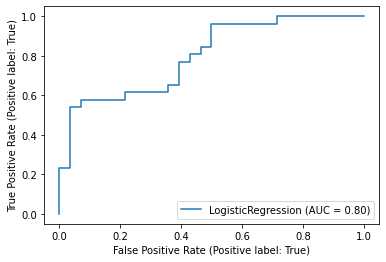

In [97]:
plot_roc_curve(model, X_test, y_test)

### XGBoost

In [98]:
model = XGBClassifier(use_label_encoder=False)
model.fit(X_train, y_train)

[20:07:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

C:\Users\olefr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


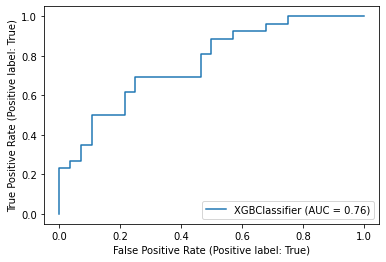

In [99]:
plot_roc_curve(model, X_test, y_test)

### Export data

In [100]:
lookup_table = data.gpls["GPL16016"].table

In [101]:
lookup_table = lookup_table.set_index("ID")

In [102]:
lookup_table.head()

,Name,miRNA_ID_LIST,Database,SPOT_ID
ID,,,,
46202,5S_rRNA,NaN,NaN,5S_rRNA
146014,bkv-miR-B1-3p/jcv-miR-J1-3p,"bkv-miR-B1-3p,jcv-miR-J1-3p",miRBase 18.0,NaN
146185,bkv-miR-B1-5p,bkv-miR-B1-5p,miRBase 18.0,NaN
17415,ebv-miR-BART10,ebv-miR-BART10,miRBase 18.0,NaN
42485,ebv-miR-BART10*,ebv-miR-BART10*,miRBase 18.0,NaN


In [103]:
mirbase = lookup_table.loc[mirnas]["miRNA_ID_LIST"]

In [104]:
from Scripts import converters

In [105]:
mask = mirbase.notna().to_numpy()
mirbase = mirbase[mask]
adj_norm_log_table = adj_norm_log_table.loc[:, mask]

In [106]:
mirbase = [m.split(",")[0] for m in mirbase]

In [107]:
sequences = converters.canonical_to_seq(mirbase, True)

In [108]:
sequences.count(None)

37

In [109]:
sequences = np.array(sequences)
mask = sequences != None
sequences = sequences[mask]
adj_norm_log_table = adj_norm_log_table.loc[:, mask]
#adj_norm_log_table /= adj_norm_log_table.var().mean()**0.5

In [110]:
adj_norm_log_table.columns = sequences
adj_norm_log_table = adj_norm_log_table.loc[:,~adj_norm_log_table.columns.duplicated()]
adj_norm_log_table["cancer"] = sick
adj_norm_log_table.head()

,UCUUUGGUUAUCUAGCUGUAUGA,UGGAAGACUUGUGAUUUUGUUGUU,UCGUACCGUGAGUAAUAAUGCG,CAGUGGUUUUACCCUAUGGUAG,UCAAAUGCUCAGACUCCUGUGGU,AUGUAUGUGUGCAUGUGCAUG,UGAGGUAGUAGUUUGUGCUGUU,CAGUGCAAUGUUAAAAGGGCAU,UGAGAACUGAAUUCCAUAGGCUG,UGGAAUGUAAAGAAGUAUGUAU,...,ACCCCACUCCUGGUACC,GAUGAGCUCAUUGUAAUAUGAG,GAUUUCAGUGGAGUGAAGUUC,AUCCCACCUCUGCCACCA,CUCCAGAGGGAUGCACUUUCU,GGCUACAACACAGGACCCGGGC,GAAAUCAAGCGUGGGUGAGACC,UAUACAAGGGCAGACUCUCUCU,CGGGGUUUUGAGGGCGAGAUGA,cancer
VALUE,0.741590,0.261356,2.109164,2.182533,-0.762065,-0.180006,1.540209,-1.088015,1.179823,-4.318497,...,1.371899,-1.114726,0.353282,-0.530247,0.030980,0.222620,0.340716,-0.417844,0.591807,1
VALUE,-0.343985,-0.013099,0.648532,3.126534,0.191934,-0.018128,0.172220,1.009291,0.992971,-3.618777,...,0.231477,-0.498167,0.590445,-0.805265,0.233680,0.929198,0.541968,-0.048067,-0.175013,1
VALUE,-0.719056,0.248140,-2.620473,0.348105,0.413945,0.397625,-1.856065,1.568414,-0.369948,-3.160005,...,-0.338053,-1.175701,0.549555,-1.787795,0.420381,-0.674744,-0.172587,-0.430029,0.108402,1
VALUE,0.037420,-0.096131,5.225930,4.702868,-0.437164,0.338143,1.972264,4.300055,3.961860,-2.760687,...,0.710115,-0.233142,0.619606,-1.968909,-0.271272,-0.545601,-0.403987,0.011012,0.189391,1
VALUE,1.623881,-0.287314,0.777111,0.083625,0.807695,-0.344286,0.743520,-0.170428,0.534185,-1.708858,...,-3.093799,-1.928689,0.110045,0.837932,0.394686,-0.596991,0.139465,-1.806821,-0.302091,1


In [111]:
adj_norm_log_table.to_csv("../TransformedData/Patnaik2017.csv", index=False)